In [ ]:
import requests
from PIL import Image
import numpy as np
import heapq
from collections import defaultdict
from io import BytesIO
import imghdr
import matplotlib.pyplot as plt
import sys
from scipy.fft import dct, idct
import glob

import holoviews as hv
import panel as pn
hv.extension('bokeh')
from IPython.display import HTML
from flask import Flask, jsonify, request

# Fonction pour récupérer l'image
def get_image_array(image_url):
    try:
        response = requests.get(image_url, headers={"User-Agent": "Scholarship_Project_Agent"})
        response.raise_for_status()  # Vérifier si la requête HTTP a réussi

        # Lire l'image à partir des données binaires
        image = Image.open(BytesIO(response.content))

        # Vérifier le format de l'image
        if imghdr.what(None, h=response.content) == "png":
            # Convertir l'image en tableau NumPy
            image_array = np.array(image)

            return image_array

        else:
            print("L'image n'est pas au format PNG.")
            return None

    except requests.exceptions.HTTPError as http_err:
        print(f"Erreur HTTP : {http_err}")
        return None
    except Exception as err:
        print(f"Erreur : {err}")
        return None

# Exemple d'utilisation :
# Source : https://commons.wikimedia.org/wiki/File:Lichtenstein_img_processing_test.png
image_url = "https://upload.wikimedia.org/wikipedia/commons/3/39/Lichtenstein_img_processing_test.png"
image = get_image_array(image_url)

if image is not None:
    plt.figure(figsize=(1,1))
    plt.imshow(image[:,:,:])

#sous-echantillonage 4:2:0
def sub_cr(Cb):
    Cb_down = np.zeros((int(Cb.shape[0]/2), int(Cb.shape[1]/2)))
    for i in range(0, Cb.shape[0], 2):
        for j in range(0, Cb.shape[1], 2):
            block = Cb[i:i+2, j:j+2]
            Cb_down[int(i/2), int(j/2)] = np.mean(block)
    return Cb_down



def split_into_blocks_numpy(image_channel, block_size=8):

    height, width = image_channel.shape

    # Calculez le nombre de blocs en hauteur et en largeur
    num_blocks_height = -(-height // block_size)  # Round up division
    num_blocks_width = -(-width // block_size)  # Round up division

    # Paddage de l'image si nécessaire
    padded_height = num_blocks_height * block_size
    padded_width = num_blocks_width * block_size

    padded_image = np.pad(image_channel, ((0, padded_height - height), (0, padded_width - width)), mode='edge')
    #le mode="edge" permet de répéter les bords du bloc en cas de division non-entière

    # Reshape pour obtenir les blocs
    blocks = padded_image.reshape(num_blocks_height, block_size, num_blocks_width, block_size)
    blocks = blocks.transpose(0, 2, 1, 3).reshape(-1, block_size, block_size)

    return blocks


def dct2D(x):
	tmp = dct(x, type=2 ,norm='ortho').transpose()#on fait une dct sur les colonnes puis on transpose
	return dct(tmp, type=2 ,norm='ortho').transpose()#on fait une dct sur les lignes puis on retranspose



# Fonction pour afficher de manière jolie les canaux après la DCT
def plot_dct_channels(Y_DCT, Cb_down_DCT, Cr_down_DCT):
    # Créer une figure avec des sous-plots
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Afficher le canal Y après la DCT
    axes[0].imshow(np.log(np.abs(Y_DCT[3]) + 1), interpolation='nearest')
    axes[0].set_title('Y Channel DCT')

    # Afficher le canal Cb après la DCT
    axes[1].imshow(np.log(np.abs(Cb_down_DCT[3]) + 1), interpolation='nearest')
    axes[1].set_title('Cb Channel DCT')

    # Afficher le canal Cr après la DCT
    axes[2].imshow(np.log(np.abs(Cr_down_DCT[3]) + 1), interpolation='nearest')
    axes[2].set_title('Cr Channel DCT')

    # Afficher la figure
    plt.show()



def quantize(block, quantization_matrix):
    quantized_block = np.round(np.divide(block, quantization_matrix)).astype(np.int64)

    return quantized_block



def dequantize(quantized_block, quantization_matrix):
    block = np.multiply(quantized_block, quantization_matrix)
    return block


# Tables de quantification classiques utilisées en JPEG
luma_table = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 40, 51, 61],
    [14, 13, 15, 20, 25, 38, 51, 60],
    [14, 17, 19, 22, 29, 44, 55, 64],
    [18, 21, 26, 34, 37, 52, 61, 66],
    [24, 26, 32, 40, 48, 58, 66, 70],
    [29, 34, 39, 48, 56, 64, 72, 76],
    [42, 49, 54, 64, 70, 77, 81, 83]
])

chroma_table = np.array([
    [17, 18, 24, 40, 51, 61, 67, 72],
    [18, 21, 26, 43, 55, 67, 72, 76],
    [21, 25, 30, 47, 62, 72, 77, 80],
    [24, 29, 34, 52, 65, 74, 79, 82],
    [27, 32, 37, 56, 70, 78, 81, 85],
    [30, 35, 39, 59, 73, 81, 84, 87],
    [53, 62, 72, 84, 92, 99, 105, 110],
    [60, 69, 77, 90, 98, 105, 110, 113]
])


# Les seuils sont basés sur des recommandations courantes pour le réglage de la qualité lors de la compression JPEG (Internet).
def quality_factor_matrix(quality, quantization_matrix):
    # Facteur de qualité entre 1 et 100
    if quality < 50:
        scale = 5000 / quality
    else:
        scale = 200 - 2 * quality

    # On ajuste les tables de quantification en fonction du facteur de qualité
    q_factor_quantization_matrix = ((quantization_matrix * quality) + 50) / 100
    q_factor_quantization_matrix = np.clip(q_factor_quantization_matrix, 1, 255)

    return q_factor_quantization_matrix

quality = 100

def quantize_image(image, quantization_matrix):
    quantized = np.copy(image)
    lenght = len(image)
    for i in range(lenght):
        quantized[i]=quantize(image[i], quantization_matrix)
    return quantized

def dequantize_image(q_image, quantization_matrix):
    quantized = np.copy(q_image)
    lenght = len(q_image)
    for i in range(lenght):
        quantized[i]=dequantize(q_image[i], quantization_matrix)
    return quantized


def zigzag_order(matrix):
    # Obtient le nombre de lignes et de colonnes de la matrice
    rows, cols = matrix.shape

    # Initialisez une liste pour stocker le résultat du parcours en zigzag
    result = []

    # Parcourt de la diagonale supérieure gauche à la diagonale inférieure droite
    for i in range(rows + cols - 1):
        if i % 2 == 0:
            # Si l'indice est pair, parcourt de haut en bas sur la diagonale
            for j in range(max(0, i - cols + 1), min(rows, i + 1)):
                result.append(matrix[j][i - j])
        else:
            # Si l'indice est impair, parcourt de bas en haut sur la diagonale
            for j in range(min(i, rows - 1), max(0, i - cols + 1) - 1, -1):
                result.append(matrix[j][i - j])

    # Retourne la liste résultante
    return result


# Fonction pour encoder les valeurs RLE
def rle_encode(data):
    encoded_data = []
    count = 1
    for i in range(1, len(data)):
        # Utiliser np.all pour comparer tous les éléments
        if np.all(data[i] == data[i - 1]):
            count += 1
        else:
            encoded_data.append((data[i - 1], count))
            count = 1
    # Ajouter la dernière séquence
    encoded_data.append((data[-1], count))
    return encoded_data


# Fonction pour encoder les valeurs RLE avec Huffman
def huffman_encode(rle_data):
    # Création d'un dictionnaire pour compter la fréquence de chaque valeur
    frequency_dict = defaultdict(int)

    for value, count in rle_data:
        # Convertir les valeurs numpy.ndarray en tuples pour les rendre hachables
        if isinstance(value, np.ndarray):
            value = tuple(value)
        frequency_dict[value] += count

    # Création d'un tas (heap) à partir du dictionnaire de fréquence
    heap = [[weight, [symbol, ""]] for symbol, weight in frequency_dict.items()]
    heapq.heapify(heap)

    # Si le tas n'a qu'un seul élément, lui assigner un code binaire fixe
    if len(heap) == 1:
        heap = [[heap[0][0], [heap[0][1][0], '0']]]

    # Combinaison des deux éléments les moins fréquents jusqu'à ce que le tas ne contienne qu'un seul élément
    while len(heap) > 1:
        lo = heapq.heappop(heap)
        hi = heapq.heappop(heap)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heapq.heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])

    # Création d'un dictionnaire Huffman à partir de l'arbre
    huffman_dict = {symbol: code for symbol, code in heap[0][1:]}

    # Encodage des données RLE en utilisant le dictionnaire Huffman
    encoded_data = "".join(huffman_dict[tuple(value)] if isinstance(value, np.ndarray) else huffman_dict[value] for value, count in rle_data for _ in range(count))

    return encoded_data, huffman_dict

def encode_blocks(blocks):
    zigzag_data, rle_data, encoded_data, huffman_dicts = [], [], [], []
    for block in blocks:
        # Zigzag Order
        zz_data = zigzag_order(block)
        zigzag_data.append(zz_data)

        # RLE Encode
        rle_data_block = rle_encode(zz_data)
        rle_data.append(rle_data_block)

        # Huffman Encode
        encoded_block, huffman_dict = huffman_encode(rle_data_block)
        encoded_data.append(encoded_block)
        huffman_dicts.append(huffman_dict)

    return encoded_data, huffman_dicts


def encode_image_to_huffman(image, quality = 100):
    #image en output
    V = image[:,:,0]
    B = image[:,:,1]
    R = image[:,:,2]
    #using coefficients of https://www.youtube.com/watch?v=Kv1Hiv3ox8I
    Y=(0.3*R+0.6*V+0.11*B)
    Cb =np.array(-0.17*R +0.5 *B - 0.33*V+128)
    Cr =np.array( 0.5*R - 0.42*V- 0.08*B+128)
    #sous echantillonnage de l'image
    Cb_down = sub_cr(Cb)
    Cr_down = sub_cr(Cr)

    Y_blocks = split_into_blocks_numpy(Y)
    Cb_down_blocks=split_into_blocks_numpy(Cb_down)
    Cr_down_blocks=split_into_blocks_numpy(Cr_down)

    Y_DCT=dct2D(Y_blocks)
    Cb_down_DCT=dct2D(Cb_down_blocks)
    Cr_down_DCT=dct2D(Cr_down_blocks)

    Y_quantized = quantize_image(Y_DCT, quality_factor_matrix(quality, luma_table))
    Cb_quantized = quantize_image(Cb_down_DCT, quality_factor_matrix(quality, chroma_table))
    Cr_quantized = quantize_image(Cr_down_DCT, quality_factor_matrix(quality, chroma_table))

    encoded_data = []
    huffman_dicts = []

    # Encoder les données Y
    encoded_Y, huffman_Y = encode_blocks(Y_quantized)
    encoded_data.append(encoded_Y)
    huffman_dicts.append(huffman_Y)

    # Encoder les données Cb
    encoded_Cb, huffman_Cb = encode_blocks(Cb_quantized)
    encoded_data.append(encoded_Cb)
    huffman_dicts.append(huffman_Cb)

    # Encoder les données Cr
    encoded_Cr, huffman_Cr = encode_blocks(Cr_quantized)
    encoded_data.append(encoded_Cr)
    huffman_dicts.append(huffman_Cr)

    return encoded_data, huffman_dicts

def calculate_entropy(huffman_code):
    unique_values, counts = np.unique(huffman_code, return_counts=True)
    probabilities = counts / len(huffman_code)

    entropy = -np.sum(probabilities * np.log2(probabilities))

    return entropy

def huffman_decode(encoded_data, huffman_dict):
    # Inverser le dictionnaire Huffman
    decode_dict = {code: symbol for symbol, code in huffman_dict.items()}

    decoded_values = []
    temp_code = ""
    for bit in encoded_data:
        temp_code += bit
        if temp_code in decode_dict:
            symbol = decode_dict[temp_code]
            decoded_values.append(symbol)
            temp_code = ""

    return decoded_values


def rle_decode(encoded_data):
    decoded_data = np.array([])
    for value, count in encoded_data:
        decoded_data = np.append(decoded_data, np.repeat(value, count))
    return decoded_data


def zigzag_decode(zigzag_data, rows, cols):
    matrix = [[0] * cols for _ in range(rows)]
    index = 0
    for i in range(rows + cols - 1):
        if i % 2 == 0:
            for j in range(max(0, i - cols + 1), min(rows, i + 1)):
                matrix[j][i - j] = zigzag_data[index]
                index += 1
        else:
            for j in range(min(i, rows - 1), max(0, i - cols + 1) - 1, -1):
                matrix[j][i - j] = zigzag_data[index]
                index += 1
    return matrix



def decode_blocks(encoded_blocks, huffman_dicts, block_size = 8):
    decoded_blocks = []
    for block_index, encoded_block in enumerate(encoded_blocks):
        huffman_dict = huffman_dicts[block_index]

        # Huffman Decode
        rle_data = huffman_decode(encoded_block, huffman_dict)

        # Zigzag Reorder to Block
        block = zigzag_decode(rle_data, block_size, block_size)
        decoded_blocks.append(block)

    return decoded_blocks


def idct2D(x):
    tmp = idct(x, type=2, norm='ortho').transpose()
    return idct(tmp, type=2, norm='ortho').transpose()



def block_into_image(channel_block):

    nb_blocks, length, width = channel_block.shape
    image_shape=int(np.sqrt(nb_blocks*length*width))
    channel=channel_block.reshape((nb_blocks,length*width))
    channel=channel.reshape((image_shape,image_shape))


    return(channel)


def combine_blocks(blocks, original_shape):
    """
    Combine les blocs dans une seule image en inversant le processus de découpage.

    Parameters:
    - blocks: Les blocs résultants du processus de découpage.
    - original_shape: La forme originale de l'image avant le découpage.

    Returns:
    - L'image reconstituée.
    """

    block_size = blocks.shape[1]  # Taille du bloc
    num_blocks_height = original_shape[0] // block_size
    num_blocks_width = original_shape[1] // block_size

    # Reshape pour obtenir les blocs dans le format original
    reshaped_blocks = blocks.reshape(num_blocks_height, num_blocks_width, block_size, block_size)

    # Transposer les axes pour obtenir la forme correcte
    transposed_blocks = reshaped_blocks.transpose(0, 2, 1, 3)

    # Reshape pour obtenir l'image originale
    reconstructed_image = transposed_blocks.reshape(original_shape)

    return reconstructed_image




def unsub_cb(Cb_down):
  val_int = 0
  Cb=np.zeros((int(Cb_down.shape[0]*2),int(Cb_down.shape[1]*2)))
  for i in range(int(Cb_down.shape[0])):
    colonne_max = (i+1)*2-1
    for j in range(int(Cb_down.shape[1])):
      ligne_max = (j+1)*2-1
      val_int = Cb_down[i,j]
      Cb[colonne_max, ligne_max] = val_int
      Cb[colonne_max, ligne_max-1] = val_int
      Cb[colonne_max-1, ligne_max] = val_int
      Cb[colonne_max-1, ligne_max-1] = val_int
  return Cb

def calculate_RGB(Y, Cb, Cr):
  R_result = 0.990 * Y  + 0.008 * (Cb - 128)+1.409*(Cr - 128)
  V_result =  0.990 * Y  -0.331 * (Cb - 128)-0.707*(Cr - 128)
  B_result =  0.990 * Y  +1.784 * (Cb - 128)+0.013*(Cr - 128)
  return(R_result,V_result,B_result)



def decode_huffman_to_image(encoded_data, huffman_dicts, quality = 100):
    # Extraire les données encodées et les dictionnaires Huffman pour chaque composante
    encoded_Y, encoded_Cb, encoded_Cr = encoded_data
    huffman_Y, huffman_Cb, huffman_Cr = huffman_dicts

    # Décoder les données Y
    decoded_Y = decode_blocks(encoded_Y, huffman_Y)

    # Décoder les données Cb
    decoded_Cb = decode_blocks(encoded_Cb, huffman_Cb)

    # Décoder les données Cr
    decoded_Cr = decode_blocks(encoded_Cr, huffman_Cr)

    # La fonction a déja été définie dans la partie quantification
    dequantized_Y = dequantize_image(decoded_Y, quality_factor_matrix(quality, luma_table))
    dequantized_Cb = dequantize_image(decoded_Cb, quality_factor_matrix(quality, chroma_table))
    dequantized_Cr = dequantize_image(decoded_Cr, quality_factor_matrix(quality, chroma_table))

    Y_IDCT_blocks=idct2D(dequantized_Y)
    Cb_down_IDCT_blocks=idct2D(dequantized_Cb)
    Cr_down_IDCT_blocks=idct2D(dequantized_Cr)

    #Y_IDCT = block_into_image(Y_IDCT_blocks)
    #Cb_down_IDCT = block_into_image(Cb_down_IDCT_blocks)
    #Cr_down_IDCT = block_into_image(Cr_down_IDCT_blocks)

    Y_IDCT = combine_blocks(Y_IDCT_blocks, original_shape=(int(np.sqrt(Y_IDCT_blocks.shape[0]*8*8)), int(np.sqrt(Y_IDCT_blocks.shape[0]*8*8))))
    Cb_down_IDCT = combine_blocks(Cb_down_IDCT_blocks, original_shape=(int(np.sqrt(Cb_down_IDCT_blocks.shape[0]*8*8)), int(np.sqrt(Cb_down_IDCT_blocks.shape[0]*8*8))))
    Cr_down_IDCT = combine_blocks(Cr_down_IDCT_blocks, original_shape=(int(np.sqrt(Cr_down_IDCT_blocks.shape[0]*8*8)), int(np.sqrt(Cr_down_IDCT_blocks.shape[0]*8*8))))

    un_cb = unsub_cb(Cb_down_IDCT)
    un_cr = unsub_cb(Cr_down_IDCT)
    # Calcul des composantes RVB
    R_result, V_result, B_result = calculate_RGB(Y_IDCT, un_cb, un_cr)

    image_result=np.stack([ V_result, B_result,R_result],axis=-1)

    return image_result



def calculate_entrop_t(image):
    """Calculate the entropy of an image."""
    if image.dtype != np.uint8:
        image = image.astype(np.uint8)
    image = image.flatten()  # Flatten the image to 1D array for histogram
    histogram = np.bincount(image, minlength=256)
    probabilities = histogram / len(image)  # Normalize to probabilities
    probabilities = probabilities[probabilities > 0]  # Exclude zero entries
    entropy = -np.sum(probabilities * np.log2(probabilities))  # Calculate entropy
    return entropy


def calculate_bin(value):
  return len(value)//8

def calculate_numpy_image_size(image):
    # Obtenir les dimensions de l'image
    height, width, channels = image.shape
    # Chaque pixel utilise 'channels' octets (typiquement 3 pour RGB)
    size_in_bytes = height * width * channels
    return size_in_bytes


def calculate_encrypted_data_size(encrypted_data):
    size_in_bytes = 0
    # La taille en bits est égale à la longueur de la chaîne
    size_in_bits = calculate_bin(encrypted_data)
    return size_in_bytes

def calculate_huffman_dict_size(huffman_dicts):
    key_size = 0
    value_size = 0
    for huffman_dict in huffman_dicts:
      for h in huffman_dict:
        for key, value in h.items():
            # Taille de la clé (entier) + taille de la valeur (chaîne binaire)
            key_size += 4 #4 octets par int et un int par key
            value_size += calculate_bin(value)  # value en binaire
    return key_size + value_size

def calculate_huffman(encoded_data, huffman_dicts):
  return calculate_encrypted_data_size(encoded_data)+calculate_huffman_dict_size(huffman_dicts)



def load_images(folder_path = "images"):
    image_paths = glob.glob(f"{folder_path}/*.png")

    images = {}

    for image_path in image_paths:
        image_name = image_path.split("/")[-1]
        image = np.array(Image.open(image_path))
        images[image_name] = image

    return images
def get_images_variables_for_entropy(images = load_images(folder_path = "images"), quality = 100):
    images_variables = {}

    for image_name, image in images.items():
        #image en output
        V = image[:,:,0]
        B = image[:,:,1]
        R = image[:,:,2]
        #using coefficients of https://www.youtube.com/watch?v=Kv1Hiv3ox8I
        Y=(0.3*R+0.6*V+0.11*B)
        Cb =np.array(-0.17*R +0.5 *B - 0.33*V+128)
        Cr =np.array( 0.5*R - 0.42*V- 0.08*B+128)
        #sous echantillonnage de l'image
        Cb_down = sub_cr(Cb)
        Cr_down = sub_cr(Cr)

        Y_blocks = split_into_blocks_numpy(Y)
        Cb_down_blocks=split_into_blocks_numpy(Cb_down)
        Cr_down_blocks=split_into_blocks_numpy(Cr_down)

        Y_DCT=dct2D(Y_blocks)
        Cb_down_DCT=dct2D(Cb_down_blocks)
        Cr_down_DCT=dct2D(Cr_down_blocks)

        Y_quantized = quantize_image(Y_DCT, quality_factor_matrix(quality, luma_table))
        Cb_quantized = quantize_image(Cb_down_DCT, quality_factor_matrix(quality, chroma_table))
        Cr_quantized = quantize_image(Cr_down_DCT, quality_factor_matrix(quality, chroma_table))

        encoded_data = []
        huffman_dicts = []

        # Encoder les données Y
        encoded_Y, huffman_Y = encode_blocks(Y_quantized)
        encoded_data.append(encoded_Y)
        huffman_dicts.append(huffman_Y)

        # Encoder les données Cb
        encoded_Cb, huffman_Cb = encode_blocks(Cb_quantized)
        encoded_data.append(encoded_Cb)
        huffman_dicts.append(huffman_Cb)

        # Encoder les données Cr
        encoded_Cr, huffman_Cr = encode_blocks(Cr_quantized)
        encoded_data.append(encoded_Cr)
        huffman_dicts.append(huffman_Cr)

        # Récupérer l'image décodée
        image_result = decode_huffman_to_image(encoded_data, huffman_dicts)

        # Stocker les informations dans le dictionnaire
        images_variables[image_name] = {
            "Image originale": image,
            "Changement base couleur": np.concatenate((Y.flatten(), Cb.flatten(), Cr.flatten()), axis=0),
            "Sous-échantillonage": np.concatenate((Y.flatten(), unsub_cb(Cb_down).flatten(), unsub_cb(Cr_down).flatten()), axis=0),
            "DCT": np.concatenate((combine_blocks(Y_DCT, original_shape = (int(image.shape[0]), int(image.shape[1]))), unsub_cb(combine_blocks(Cb_down_DCT, original_shape = (int(image.shape[0]/2), int(image.shape[1]/2)))), unsub_cb(combine_blocks(Cr_down_DCT, original_shape = (int(image.shape[0]/2), int(image.shape[1]/2))))), axis=0),
            "Quantification": np.concatenate((combine_blocks(Y_quantized, original_shape = (int(image.shape[0]), int(image.shape[1]))), unsub_cb(combine_blocks(Cb_quantized, original_shape = (int(image.shape[0]/2), int(image.shape[1]/2)))), unsub_cb(combine_blocks(Cr_quantized, original_shape = (int(image.shape[0]/2), int(image.shape[1]/2))))), axis=0),
            "Image décodée": image_result
        }

        return images_variables

def get_images_variables_entropy(images_variables):
    images_variables_entropy = {}

    for image_name, image_data in images_variables.items():
        images_variables_entropy[image_name] = {}
        for key, value in image_data.items():
            images_variables_entropy[image_name][key] = calculate_entrop_t(value)

    return images_variables_entropy



# Fonction pour tracer le graphique en barres en fonction de l'image et de la qualité
def plot_entropy(image_name, quality):
    images_variables = get_images_variables_for_entropy(images, quality)
    images_variables_entropy = get_images_variables_entropy(images_variables)

    image_data = images_variables_entropy[image_name]

    # Extraction des noms des composantes et de leurs entropies
    components = list(image_data.keys())
    entropies = [image_data[component] for component in components]

    # Calculer le pourcentage de l'entropie par rapport à l'entropie de l'image originale
    original_entropy = image_data['Image originale']
    entropies_percentage = [entropy / original_entropy * 100 for entropy in entropies]

    # Création du bar plot pour l'image sélectionnée
    bar_plot = hv.Bars((components, entropies_percentage)).opts(
        xlabel='Composantes de l\'image', ylabel='Entropie en pourcentage de l\'image originale',
        title=f'Entropie des composantes pour {image_name}', width=600, height=400,
        xrotation=45, tools=['hover'])

    return bar_plot

def get_images_variables_for_byte(images = load_images(folder_path = "images"), quality = 100):
    images_variables = {}

    for image_name, image in images.items():
        #image en output
        V = image[:,:,0]
        B = image[:,:,1]
        R = image[:,:,2]
        #using coefficients of https://www.youtube.com/watch?v=Kv1Hiv3ox8I
        Y=(0.3*R+0.6*V+0.11*B)
        Cb =np.array(-0.17*R +0.5 *B - 0.33*V+128)
        Cr =np.array( 0.5*R - 0.42*V- 0.08*B+128)
        #sous echantillonnage de l'image
        Cb_down = sub_cr(Cb)
        Cr_down = sub_cr(Cr)

        Y_blocks = split_into_blocks_numpy(Y)
        Cb_down_blocks=split_into_blocks_numpy(Cb_down)
        Cr_down_blocks=split_into_blocks_numpy(Cr_down)

        Y_DCT=dct2D(Y_blocks)
        Cb_down_DCT=dct2D(Cb_down_blocks)
        Cr_down_DCT=dct2D(Cr_down_blocks)

        Y_quantized = quantize_image(Y_DCT, quality_factor_matrix(quality, luma_table))
        Cb_quantized = quantize_image(Cb_down_DCT, quality_factor_matrix(quality, chroma_table))
        Cr_quantized = quantize_image(Cr_down_DCT, quality_factor_matrix(quality, chroma_table))

        encoded_data = []
        huffman_dicts = []

        # Encoder les données Y
        encoded_Y, huffman_Y = encode_blocks(Y_quantized)
        encoded_data.append(encoded_Y)
        huffman_dicts.append(huffman_Y)

        # Encoder les données Cb
        encoded_Cb, huffman_Cb = encode_blocks(Cb_quantized)
        encoded_data.append(encoded_Cb)
        huffman_dicts.append(huffman_Cb)

        # Encoder les données Cr
        encoded_Cr, huffman_Cr = encode_blocks(Cr_quantized)
        encoded_data.append(encoded_Cr)
        huffman_dicts.append(huffman_Cr)

        # Récupérer l'image décodée
        image_result = decode_huffman_to_image(encoded_data, huffman_dicts)

        # Stocker les informations dans le dictionnaire
        images_variables[image_name] = {
            "Image originale": image,
            "Encodage d'Huffman": (encoded_data, huffman_dicts),
            "Image décodée": image_result
        }

        return images_variables

def get_images_variables_byte(images_variables):
    images_variables_byte = {}

    for image_name, image_data in images_variables.items():

        # Stocker les informations dans le dictionnaire
        images_variables_byte[image_name] = {
            "Image originale": calculate_numpy_image_size(image_data["Image originale"]),
            "Encodage d'Huffman": calculate_huffman(image_data["Encodage d'Huffman"][0], image_data["Encodage d'Huffman"][1]),
            "Image décodée": calculate_numpy_image_size(image_data["Image décodée"])
        }
        

    return images_variables_byte



# Fonction pour tracer le graphique en barres en fonction de l'image et de la qualité
def plot_byte(image_name, quality):
    images_variables = get_images_variables_for_byte(images, quality)
    images_variables_byte = get_images_variables_byte(images_variables)

    image_data = images_variables_byte[image_name]

    # Extraction des noms des composantes et de leurs bytes
    components = list(image_data.keys())
    bytes = [image_data[component] for component in components]

    # Calculer le pourcentage de l'entropie par rapport à l'entropie de l'image originale
    original_byte = image_data['Image originale']
    bytes_percentage = [byte / original_byte * 100 for byte in bytes]

    # Création du bar plot pour l'image sélectionnée
    bar_plot = hv.Bars((components, bytes_percentage)).opts(
        xlabel='Composantes de l\'image', ylabel='Entropie en pourcentage de l\'image originale',
        title=f'Entropie des composantes pour {image_name}', width=600, height=400,
        xrotation=45, tools=['hover'])

    return bar_plot
def plot_fig_entropy(obj, name,entrop=True):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    list_entrop = []
    for i, (k, j) in enumerate(zip(obj, name)):
        axs[i].imshow(k)
        axs[i].set_title(j)
        list_entrop.append(k.flatten())
    plt.tight_layout()
    plt.show()
    if entrop:
        entropy_color=calculate_entrop_t(np.concatenate(list_entrop, axis=0))
        return entropy_color

def unsub_cb(Cb_down):
  val_int = 0
  Cb=np.zeros((int(Cb_down.shape[0]*2),int(Cb_down.shape[1]*2)))
  for i in range(int(Cb_down.shape[0])):
    colonne_max = (i+1)*2-1
    for j in range(int(Cb_down.shape[1])):
      ligne_max = (j+1)*2-1
      val_int = Cb_down[i,j]
      Cb[colonne_max, ligne_max] = val_int
      Cb[colonne_max, ligne_max-1] = val_int
      Cb[colonne_max-1, ligne_max] = val_int
      Cb[colonne_max-1, ligne_max-1] = val_int
  return Cb

def combine_blocks(blocks, original_shape):
    """
    Combine les blocs dans une seule image en inversant le processus de découpage.

    Parameters:
    - blocks: Les blocs résultants du processus de découpage.
    - original_shape: La forme originale de l'image avant le découpage.

    Returns:
    - L'image reconstituée.
    """

    block_size = blocks.shape[1]  # Taille du bloc
    num_blocks_height = original_shape[0] // block_size
    num_blocks_width = original_shape[1] // block_size

    # Reshape pour obtenir les blocs dans le format original
    reshaped_blocks = blocks.reshape(num_blocks_height, num_blocks_width, block_size, block_size)

    # Transposer les axes pour obtenir la forme correcte
    transposed_blocks = reshaped_blocks.transpose(0, 2, 1, 3)

    # Reshape pour obtenir l'image originale
    reconstructed_image = transposed_blocks.reshape(original_shape)

    return reconstructed_image

# JPEG Compression
Membres du groupe :
- Alexandre Blain
- Paul Corbalan
- Johan Lagardère
- Younès Loulidi

Département Génie Mathématique et Modélisation

INSA Toulouse

# Introduction

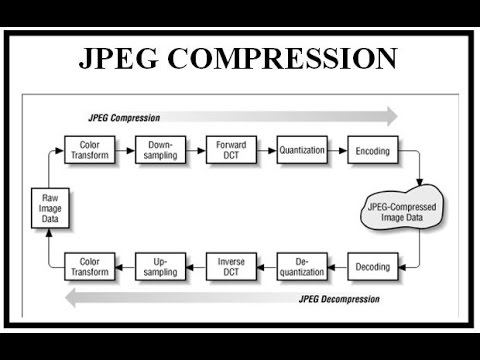


In [ ]:
-images numériques combinaison de bits et leur résolution a été croissante
depuis l'apparition d'internet
-Pourquoi a-ton besoin de compression?
    sans compression 45 000 images en 4K =1 To d'espace de stockage
-JPEG format de compression d'image le plus utilisé du monde 86% des images
car il permet de diviser la place en mémoire tout en conservant la résolution 
-Nous allons nous intéresser aux différentes étapes ...

# Entropie

L'entropie $H(X)$ est calculée comme $H(X) =  -\sum_{i} P(x_i) \log(P(x_i)) $ ou $P(x_{i})$ est la probabilité d'occurrence de la i-ème valeur unique d'un codage(une image).

In [ ]:
def calculate_entrop_t(image):
    """Calculate the entropy of an image."""
    if image.dtype != np.uint8:
        image = image.astype(np.uint8)
    image = image.flatten()  # Flatten the image to 1D array for histogram
    histogram = np.bincount(image, minlength=256)
    probabilities = histogram / len(image)  # Normalize to probabilities
    probabilities = probabilities[probabilities > 0]  # Exclude zero entries
    entropy = -np.sum(probabilities * np.log2(probabilities))  # Calculate entropy
    return entropy

In [ ]:
if image is not None:
  plt.figure(figsize=(5,5))
  plt.imshow(image[:,:,:])
entropy_image=calculate_entrop_t(image)
print("Entropie de l'image initiale : ", entropy_image)

## Base de couleur et sous-échantillonage

L'utilisation d'un espace colorimétrique YCbCr permet d'optimiser la compression en exploitant les caractéristiques de perception visuelle humaine, où la sensibilité aux détails de chrominance est moindre par rapport à la luminance.


\begin{equation}
Y = 0.3R+0.6V+0.11B
\end{equation}

\begin{align*}
Cb &= -0.17R +0.5B - 0.33V+128 \\
Cr &= 0.5R - 0.42V- 0.08B+128
\end{align*}

In [ ]:
#séparation d'image en channels
V = image[:,:,0]
B = image[:,:,1]
R = image[:,:,2]

#conversion to YCbCr
Y=(0.3*R+0.6*V+0.11*B)
Cb =np.array(-0.17*R +0.5 *B - 0.33*V+128)
Cr =np.array( 0.5*R - 0.42*V- 0.08*B+128)

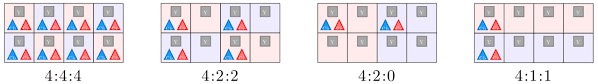


In [ ]:
#sous echantillonnage de l'image
Cb_down = sub_cr(Cb)
Cr_down = sub_cr(Cr)
ent = calculate_entrop_t(np.concatenate((Y, unsub_cb(Cb_down), unsub_cb(Cr_down))))
plot_fig_entropy([Y, Cr_down, Cb_down], ['Image Y', 'Image Cr_down', 'Image Cb_down'], entrop = False)
print(f'L\'entropie après Changement de base et sous-échantillonage vaut {int(100*ent/entropy_image)}% de l\'entropie initiale')

## Découpage en Blocs


In [ ]:
En moyenne dans une image on a souvent peu d'information sur des blocs 8*8 
surtout si arrière plan lisse: ex ciel. 
Nous allons donc découper nos channels en bloc de taille 8*8

In [ ]:
Y_blocks = split_into_blocks_numpy(Y)
Cb_down_blocks=split_into_blocks_numpy(Cb_down)
Cr_down_blocks=split_into_blocks_numpy(Cr_down)
plot_fig_entropy([Y_blocks[1,:,:], Cr_down_blocks[1,:,:], Cb_down_blocks[1,:,:]], ['Y blocks', 'Cr_down_blocks', ' Cb_down_blocks'], entrop = False)

## Transformée en Cosinus Discrète(DCT)

On transforme notre image dans le domaine fréquentiel.\
Pour un coefficient DCT unique dans un bloc 8x8, la formule est donnée par :
$$
 F(u, v) = \frac{1}{4} C(u) C(v)\sum_{x=0}^{7}\sum_{y=0}^{7}(f(x, y)-128)\cos\left[\frac{(2x+1)u\pi}{16}\right]\cos\left[\frac{(2y+1)v\pi}{16}\right]
$$

L'humain perçoit mieux les basses fréquences que les hautes fréquences dans une image.

In [ ]:
Y_DCT=dct2D(Y_blocks)
Cb_down_DCT=dct2D(Cb_down_blocks)
Cr_down_DCT=dct2D(Cr_down_blocks)
plot_dct_channels(Y_DCT, Cb_down_DCT, Cr_down_DCT)
ent_DCT=calculate_entrop_t(np.concatenate((combine_blocks(Y_DCT, original_shape = (int(image.shape[0]), int(image.shape[1]))), unsub_cb(combine_blocks(Cb_down_DCT, original_shape = (int(image.shape[0]/2), int(image.shape[1]/2)))), unsub_cb(combine_blocks(Cr_down_DCT, original_shape = (int(image.shape[0]/2), int(image.shape[1]/2))))), axis=0))
print(f'Entropie après la DCT vaut {int(100*ent_DCT/entropy_image)}% de l\'entropie initiale')

# Quantification
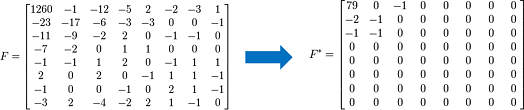


Les tables de quantification de base que nous allons utiliser dans ce projet ont été trouvées sur Internet : elles sont classiques et souvent utilisées pour la compression JPEG.

La table utilisée pour la luminance est :
$$T_Y = \begin{bmatrix}
    16 & 11 & 10 & 16 & 24 & 40 & 51 & 61 \\
    12 & 12 & 14 & 19 & 26 & 40 & 51 & 61 \\
    14 & 13 & 15 & 20 & 25 & 38 & 51 & 60 \\
    14 & 17 & 19 & 22 & 29 & 44 & 55 & 64 \\
    18 & 21 & 26 & 34 & 37 & 52 & 61 & 66 \\
    24 & 26 & 32 & 40 & 48 & 58 & 66 & 70 \\
    29 & 34 & 39 & 48 & 56 & 64 & 72 & 76 \\
    42 & 49 & 54 & 64 & 70 & 77 & 81 & 83 \\
\end{bmatrix}.$$ 

La table utilisée pour les chrominances rouge et bleue est :

$$T_{Cr} = T_{Cb} = \begin{bmatrix}
    17 & 18 & 24 & 40 & 51 & 61 & 67 & 72 \\
    18 & 21 & 26 & 43 & 55 & 67 & 72 & 76 \\
    21 & 25 & 30 & 47 & 62 & 72 & 77 & 80 \\
    24 & 29 & 34 & 52 & 65 & 74 & 79 & 82 \\
    27 & 32 & 37 & 56 & 70 & 78 & 81 & 85 \\
    30 & 35 & 39 & 59 & 73 & 81 & 84 & 87 \\
    53 & 62 & 72 & 84 & 92 & 99 & 105 & 110 \\
    60 & 69 & 77 & 90 & 98 & 105 & 110 & 113 \\
\end{bmatrix}.$$


## Facteur de qualité 
Il est possible de choisir le niveau de compression d’une image via un facteur de qualité. Ceci modifie par conséquent les termes présents dans les tables de quantification. Plus les termes sont élevés, plus la matrice résultante contiendra de zéros.

In [ ]:
Y_quantized = quantize_image(Y_DCT, quality_factor_matrix(quality, luma_table))
Cb_quantized = quantize_image(Cb_down_DCT, quality_factor_matrix(quality, chroma_table))
Cr_quantized = quantize_image(Cr_down_DCT, quality_factor_matrix(quality, chroma_table))
plot_dct_channels(Y_quantized, Cb_quantized, Cr_quantized)
entropy_quantized=calculate_entrop_t(np.concatenate((combine_blocks(Y_quantized, original_shape = (int(image.shape[0]), int(image.shape[1]))), unsub_cb(combine_blocks(Cb_quantized, original_shape = (int(image.shape[0]/2), int(image.shape[1]/2)))), unsub_cb(combine_blocks(Cr_quantized, original_shape = (int(image.shape[0]/2), int(image.shape[1]/2))))), axis=0))
print(f'Entropie après la DCT vaut {int(100*entropy_quantized/entropy_image)}% de l\'entropie initiale')

## Nouvelle métrique : Place mémoire
A partir de là, plus de modification de l'information mais une réorganisation de celle-ci\
nombre binaire -> 1 bit\
int -> 32 bits

In [ ]:
print(f'Taille de l\'image de base : {calculate_numpy_image_size(image)} octets')

## Entropy Encoding, RLE et Huffman encoding

### Run Length Encoding (RLE)

\begin{equation*}
    [1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3]
    \xrightarrow{\text{RLE}}
    [(1, 5), (2, 3), (3, 4)]
\end{equation*}

### Huffman encoding
**Etape 1 : Calcul des fréquences :**

\begin{array}{cccc}
\text{Coefficient} & \text{Fréquence} \\
A & 14  \\
B & 6  \\
C & 3  \\
D & 2 \\
\end{array}

**Etape 2 : Déterminer l'arbre de Huffman (table de codage) :**

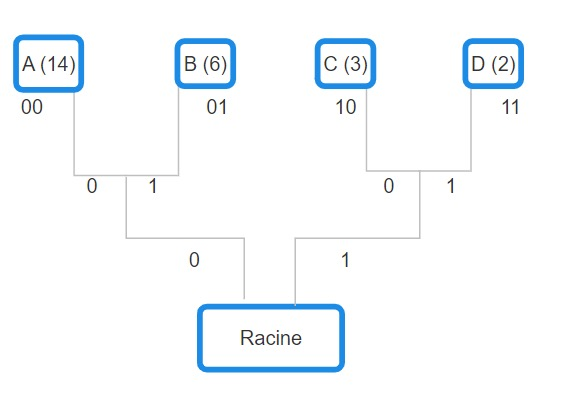

**Etape 3 : Codage:**

\begin{array}{cccc}
\text{Coefficient} & \text{Fréquence} & \text{Code Huffman} \\
A & 14 & 00\\
B & 6 & 01 \\
C & 3  &10 \\
D & 2 &11 \\
\end{array}

In [ ]:
encoded_data, huffman_dicts = encode_image_to_huffman(image)
print("Encodage d'Huffman :", encoded_data[0][0], sep = '\n', end = '\n---\n')
print("Dictionnaire d'Huffman :", huffman_dicts[0][0], sep = '\n', end = '\n---\n')
print(f'Taille du codage de Hauffman : {calculate_huffman(encoded_data, huffman_dicts)} octets')
print(f'Taille de l\'image de base : {calculate_numpy_image_size(image)} octets')
print(f'Pourcentage gagné : {100*calculate_numpy_image_size(image)/calculate_huffman(encoded_data, huffman_dicts)} %')

## Pour aller plus loin
### Test pour plusieurs seuils de qualités

In [ ]:
images = load_images(folder_path="images")
quality_slider = pn.widgets.IntSlider(name='Qualité', start=50, end=100, step=5, value=100)
dropdown = pn.widgets.Select(name='Choisissez une image', options=list(images.keys()))
@pn.depends(dropdown.param.value, quality_slider.param.value)
def update_plot(image_name, quality):
    return plot_entropy(image_name, quality)
layout = pn.Row(pn.Column(dropdown, quality_slider), update_plot)
layout.servable()

In [ ]:
images = load_images(folder_path="images")
quality_slider = pn.widgets.IntSlider(name='Qualité', start=50, end=100, step=5, value=100)
dropdown = pn.widgets.Select(name='Choisissez une image', options=list(images.keys()))
@pn.depends(dropdown.param.value, quality_slider.param.value)
def update_plot(image_name, quality):
    return plot_byte(image_name, quality)
layout = pn.Row(pn.Column(dropdown, quality_slider), update_plot)
layout.servable()

### Extension Google Chrome